# HMK2 - How big is your world
## Estudiante: Andrés Calderón
### CCAS4501-1 Astroinformática

---

<br/>
Importamos las librerías necesarias para realizar la tarea:

In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## P1) Analizar imagen FFI de planeta escogido en TESS

Para esta tarea elegimos el planeta $\textbf{TOI-125b}$, particularmente el sector 69:

In [2]:
search_result = lk.search_targetpixelfile('TOI125b', mission='TESS')

In [3]:
search_result

SearchResult containing 11 data products.

 #     mission     year   author  exptime target_name distance
                                     s                 arcsec 
--- -------------- ---- --------- ------- ----------- --------
  0 TESS Sector 01 2018      SPOC     120    52368076      0.0
  1 TESS Sector 02 2018      SPOC     120    52368076      0.0
  2 TESS Sector 28 2020      SPOC      20    52368076      0.0
  3 TESS Sector 28 2020      SPOC     120    52368076      0.0
  4 TESS Sector 68 2023      SPOC      20    52368076      0.0
  5 TESS Sector 69 2023      SPOC      20    52368076      0.0
  6 TESS Sector 68 2023      SPOC     120    52368076      0.0
  7 TESS Sector 69 2023      SPOC     120    52368076      0.0
  8 TESS Sector 01 2018 TESS-SPOC    1800    52368076      0.0
  9 TESS Sector 02 2018 TESS-SPOC    1800    52368076      0.0
 10 TESS Sector 28 2020 TESS-SPOC     600    52368076      0.0

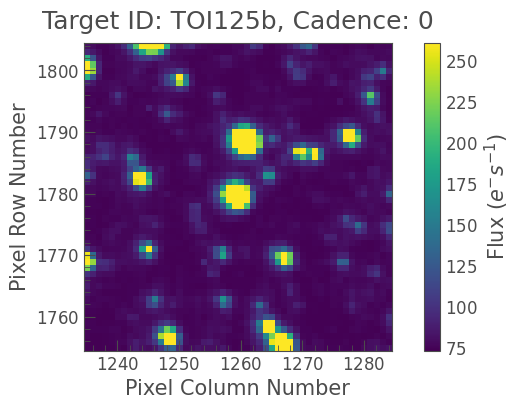

In [4]:
target = 'TOI125b'
sector = 69
tpf = lk.search_tesscut(target=target, sector=sector).download(cutout_size=(50, 50))
tpf.plot();

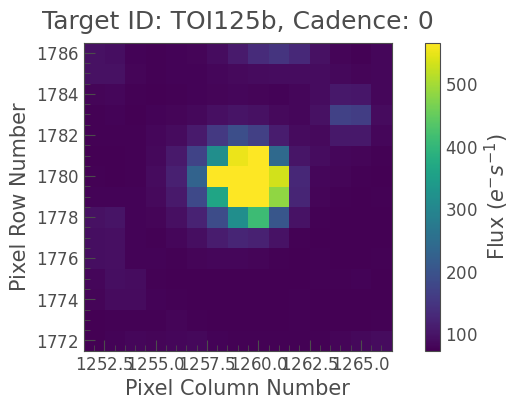

In [5]:
tpf = lk.search_tesscut(target=target, sector=sector).download(cutout_size=(15, 15))
tpf.plot();

In [6]:
tpf.animate()

### 1. Análisis preliminar:

Para establecer una valoración sobre la dispersión de la luz primero elegiremos un umbral adecuado para la máscara de la apertura, en este caso, no es tan relevante cual valor usar mientras no se utilice uno muy bajo, dado que el planeta que se está analizando, bajo este cutout de 15x15, no está rodeado de más estrellas que hagan ruido, por lo que se eligió un valor de 17 sigmas, el cual reconoce bastante bien este flujo.

Para

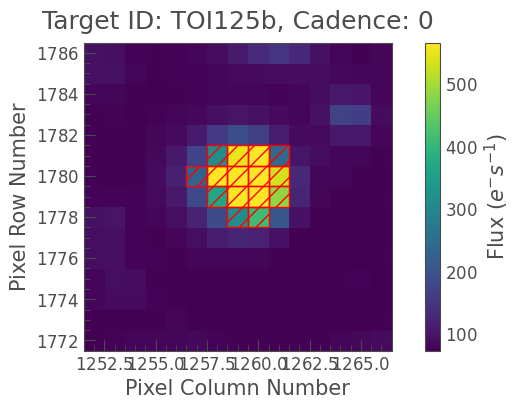

In [7]:
aper = tpf.create_threshold_mask(17)
tpf.plot(aperture_mask=aper);

Aquí se visualiza el background y el borde respectivamente:

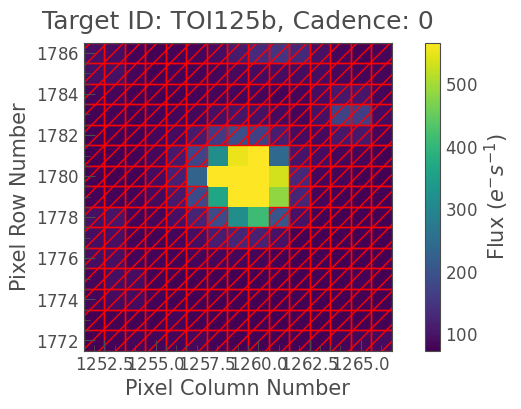

In [8]:
back = (tpf.create_threshold_mask(threshold=-100).astype(int) - aper.astype(int)).astype(bool)
tpf.plot(aperture_mask=back);

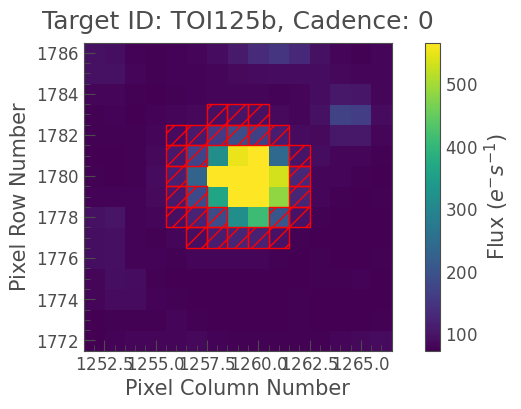

In [9]:
outer_region = (tpf.create_threshold_mask(threshold=1).astype(int) - aper.astype(int)).astype(bool)
tpf.plot(aperture_mask=outer_region);

Dadas las características del sector, al cambiar la máscara de la apertura esta apenas cambia los resultados puesto que la diferencia de píxeles seleccionados es muy pequeña.

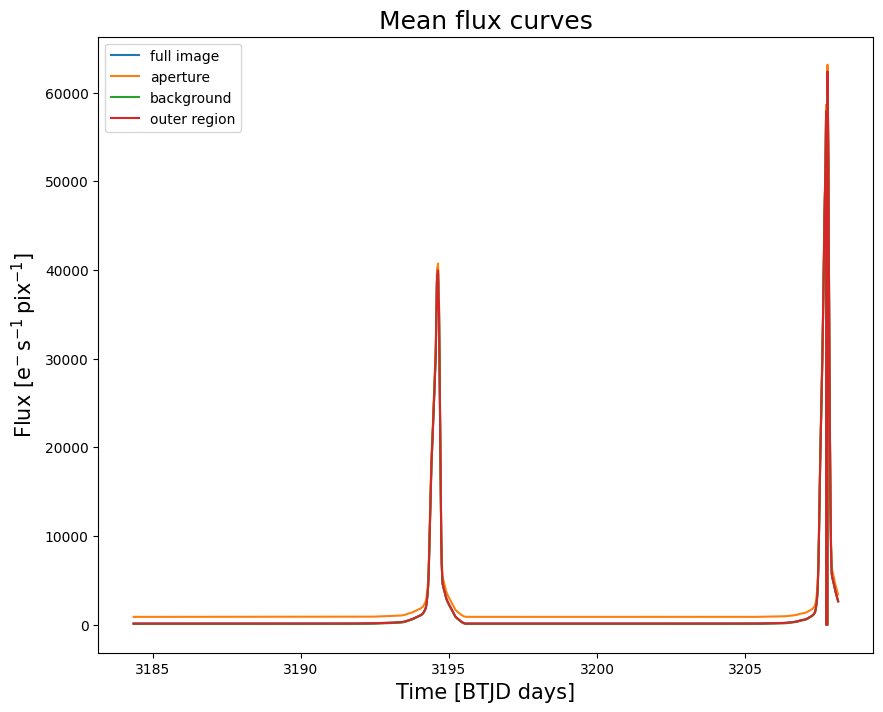

In [10]:
plt.figure(figsize=(10,8))
plt.title('Mean flux curves', fontsize=18)

# Visualize tpf flux [Full cut]:
plt.plot(tpf.time.value, np.mean(tpf.flux, axis=(1,2)), label='full image')

# Visualize tpf flux [aperture region]:
plt.plot(tpf.time.value, np.mean(tpf.flux[:, aper], axis=1), label='aperture')

# Visualize tpf flux [background]:
plt.plot(tpf.time.value, np.mean(tpf.flux[:, back], axis=1), label='background')

# Visualize tpf flux [outer region]:
plt.plot(tpf.time.value, np.mean(tpf.flux[:, outer_region], axis=1), label='outer region')

plt.ylabel('Flux [$\\mathrm{e^{-}\\,s^{-1}\\,pix^{-1}}$]', fontsize=15)
plt.xlabel('Time [BTJD days]', fontsize=15)
plt.legend()
plt.show();

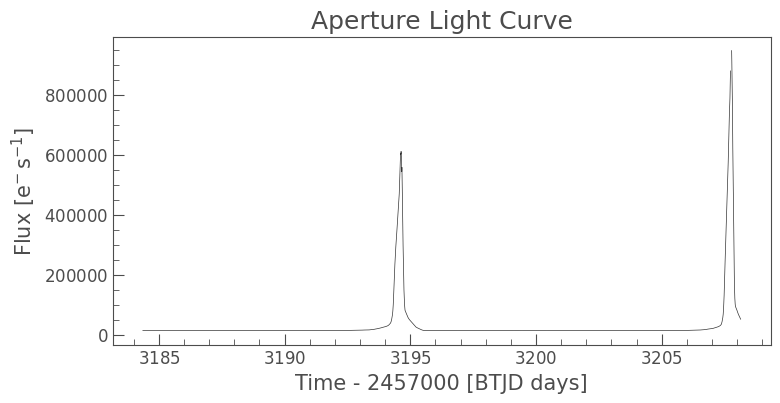

In [11]:
uncorrected_lc = tpf.to_lightcurve(aperture_mask=aper)
uncorrected_lc.plot()
plt.title('Aperture Light Curve', fontsize=18)
plt.show();

De estos gráficos ya se puede visualizar que la curva sin corregir solo posee dos peaks los cuales serán interferencias con la medida de la dispersión de luz que estamos analizando, por lo que ahora procedemos a corregirla:

### 2. Corrección:

Para corregir la curva de luz del planeta utilizaremos el método de PLD, el cual consiste en 


c:\Users\ninja\OneDrive\Escritorio\Academicos\DAS\Astroinformatica\venv\lib\site-packages\astropy\utils\decorators.py:604: LightkurveDeprecationWarning: "aperture_mask" was deprecated in version 2.0 and will be removed in a future version. 
  return function(*args, **kwargs)
c:\Users\ninja\OneDrive\Escritorio\Academicos\DAS\Astroinformatica\venv\lib\site-packages\patsy\util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)


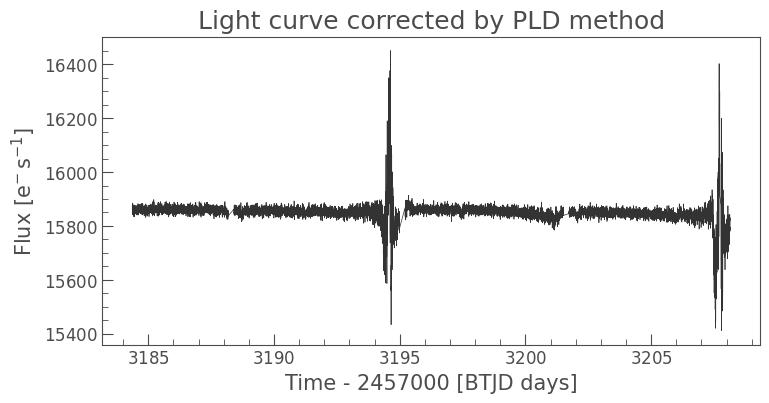

In [58]:
corrector = tpf.to_corrector('pld')
lc = corrector.correct(aperture_mask=aper)
lc.plot()
plt.title('Light curve corrected by PLD method', fontsize=18)
plt.show();

De este gráfico podemos ver que no hay tantas variaciones de la estrella lo que nos permite identificar dos gaps en esta con profundidades muy similares, de modo que podemos 

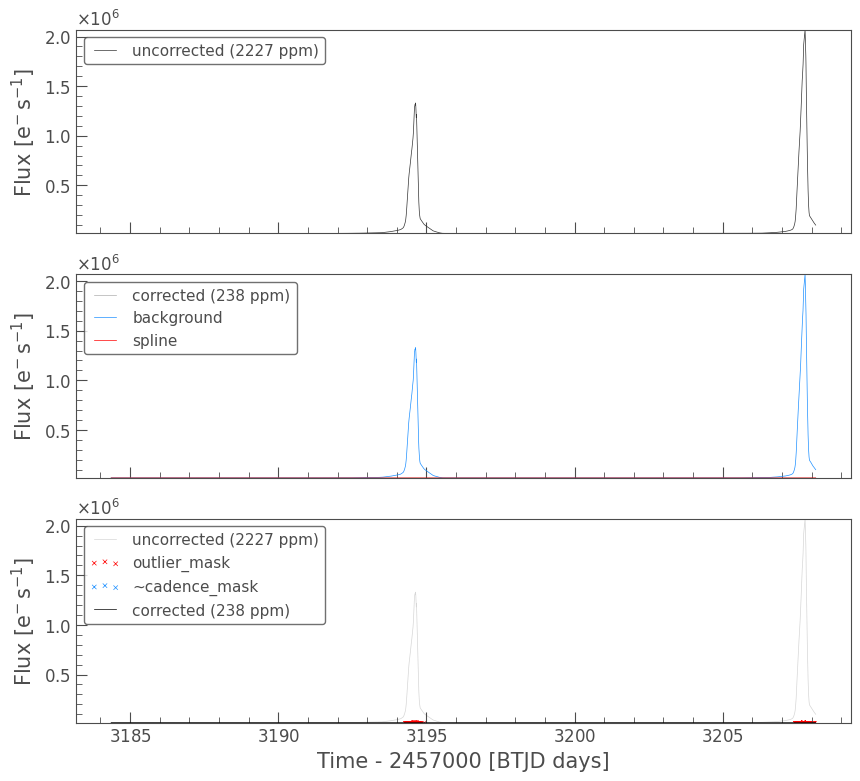

In [25]:
corrector.diagnose()
plt.show();

escribir algo no se lol #############################################

### 3. Acercamiento alternativo:

Para este caso realizaremos una sustracción del promedio del flujo en el borde con el flujo de cada píxel en la apertura para eliminar el ruido:

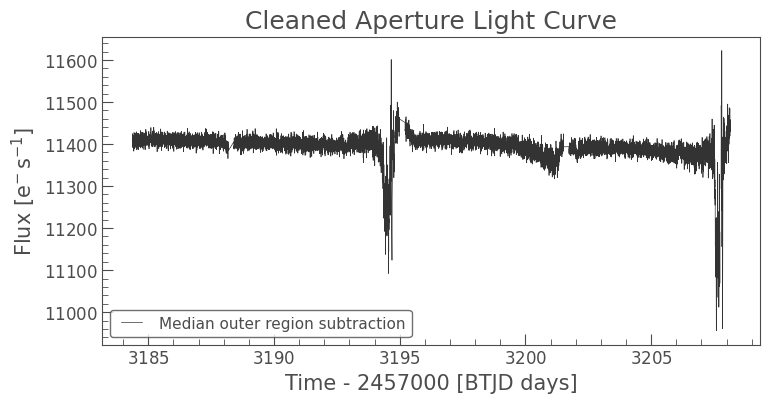

In [112]:
mean_subtracted_lc = uncorrected_lc - aper.sum()*np.mean(tpf.flux[:, outer_region], axis=1)

mean_subtracted_lc.plot(label='Median outer region subtraction')
plt.title('Cleaned Aperture Light Curve', fontsize=18)
plt.show();

A diferencia del primer método usado aqui hay un poco más de variación en la curva corregida y aunque se mantienen los dos gaps estos tienen profundidades distintas

# Target Pixel File

lightkurve example: [link](https://docs.lightkurve.org/tutorials/3-science-examples/exoplanets-identifying-transiting-planet-signals.html)

In [24]:
search_result = lk.search_targetpixelfile('TOI1268b', mission='TESS')
search_result

SearchResult containing 12 data products.

 #     mission     year   author  exptime target_name distance
                                     s                 arcsec 
--- -------------- ---- --------- ------- ----------- --------
  0 TESS Sector 15 2019      SPOC     120   142394656      0.0
  1 TESS Sector 21 2020      SPOC     120   142394656      0.0
  2 TESS Sector 22 2020      SPOC     120   142394656      0.0
  3 TESS Sector 41 2021      SPOC     120   142394656      0.0
  4 TESS Sector 48 2022      SPOC     120   142394656      0.0
  5 TESS Sector 49 2022      SPOC     120   142394656      0.0
  6 TESS Sector 15 2019 TESS-SPOC    1800   142394656      0.0
  7 TESS Sector 21 2020 TESS-SPOC    1800   142394656      0.0
  8 TESS Sector 22 2020 TESS-SPOC    1800   142394656      0.0
  9 TESS Sector 41 2021 TESS-SPOC     600   142394656      0.0
 10 TESS Sector 48 2022 TESS-SPOC     600   142394656      0.0
 11 TESS Sector 49 2022 TESS-SPOC     600   142394656      0.0

In [25]:
tpf_collection = search_result.download_all()

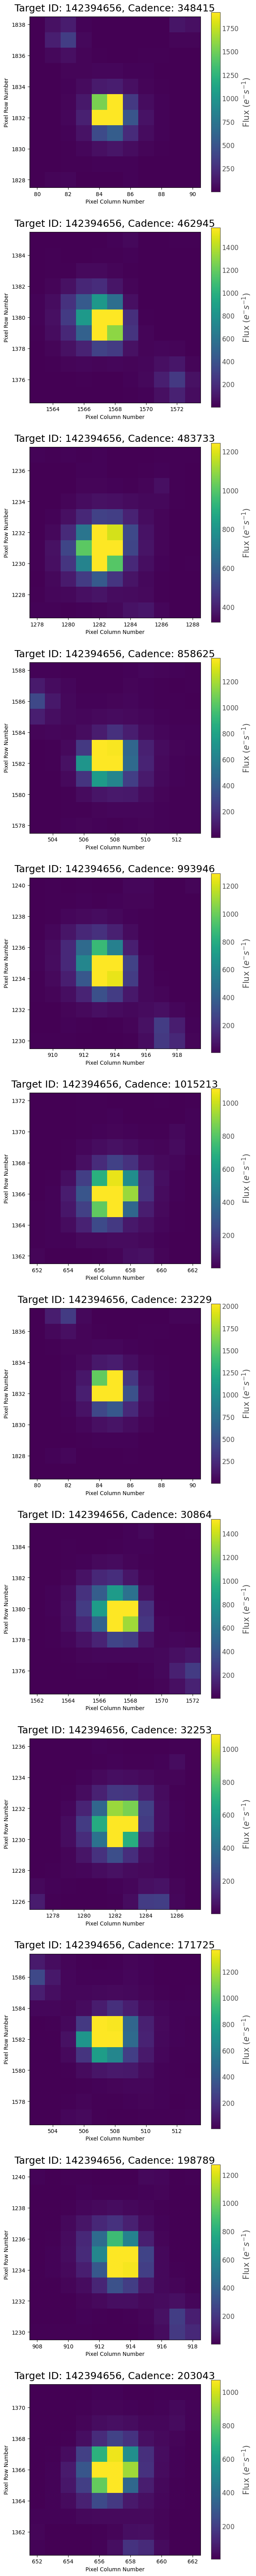

In [26]:
tpf_collection.plot();

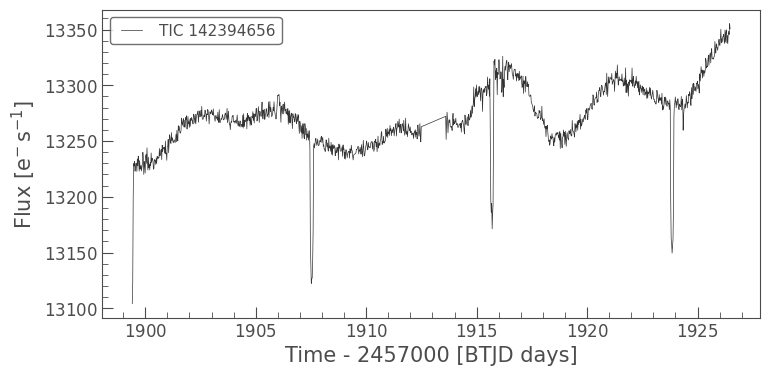

In [27]:
tpf_collection[8].to_lightcurve().plot();

In [41]:
search_result_lc = lk.search_lightcurve('TOI1268b', mission='TESS')
search_result_lc

SearchResult containing 22 data products.

 #     mission     year   author  exptime target_name distance
                                     s                 arcsec 
--- -------------- ---- --------- ------- ----------- --------
  0 TESS Sector 15 2019      SPOC     120   142394656      0.0
  1 TESS Sector 22 2020      SPOC     120   142394656      0.0
  2 TESS Sector 21 2020      SPOC     120   142394656      0.0
  3 TESS Sector 41 2021      SPOC     120   142394656      0.0
  4 TESS Sector 49 2022      SPOC     120   142394656      0.0
  5 TESS Sector 48 2022      SPOC     120   142394656      0.0
  6 TESS Sector 15 2019 TESS-SPOC    1800   142394656      0.0
  7 TESS Sector 21 2020 TESS-SPOC    1800   142394656      0.0
  8 TESS Sector 22 2020 TESS-SPOC    1800   142394656      0.0
  9 TESS Sector 41 2021 TESS-SPOC     600   142394656      0.0
 10 TESS Sector 48 2022 TESS-SPOC     600   142394656      0.0
 11 TESS Sector 49 2022 TESS-SPOC     600   142394656      0.0
 12 TESS Sector 15 2019       QLP    1800   142394656      0.0
 13 TESS Sector 22 2020       QLP    1800   142394656      0.0
 14 TESS Sector 21 2020       QLP    1800   142394656      0.0
 15 TESS Sector 41 2021       QLP     600   142394656      0.0
 16 TESS Sector 48 2022       QLP     600   142394656      0.0
 17 TESS Sector 49 2022       QLP     600   142394656      0.0
 18 TESS Sector 15 2019     TASOC     120   142394656      0.0
 19 TESS Sector 15 2019     TASOC    1800   142394656      0.0
 20 TESS Sector 15 2019     TASOC    1800   142394656      0.0
 21   TESS Sector  2019  DIAMANTE    1800   142394656      0.0

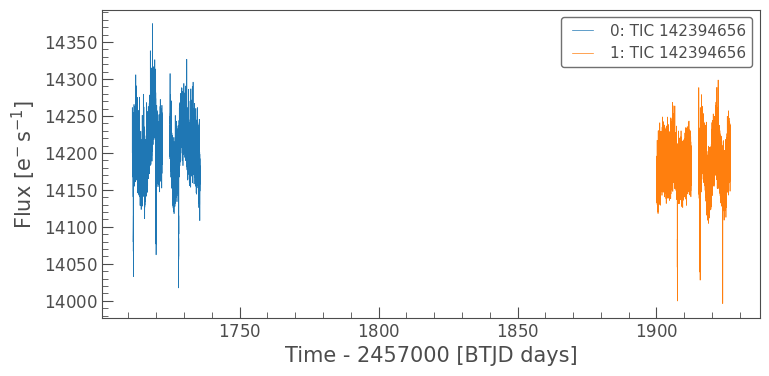

In [29]:
lc_collection = search_result_lc[[0,1]].download_all()
lc_collection.plot();

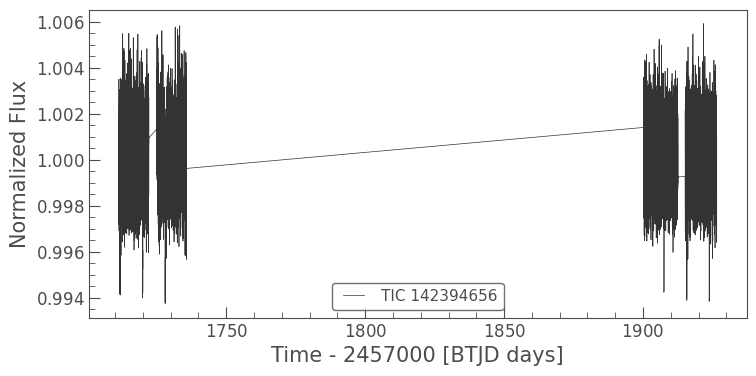

In [30]:
# Flatten the light curve
lc = lc_collection.stitch().flatten(window_length=1000).remove_outliers()
lc.plot();

The function "*to_periodogram()*" includes an argument called "*method*" which specifies the method used to compute the periodogram. In this case, I will use "bls" (Box Least Squares), which searches for periodic events in the data by assuming they appear as box-like shapes. This method should be sufficient to identify what we are searching for.

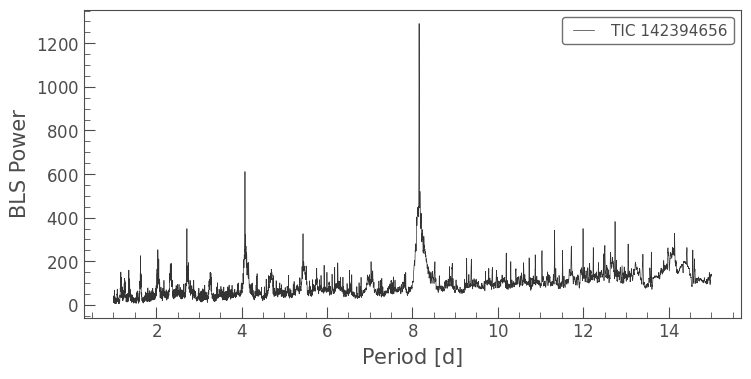

In [31]:
# Create array of periods to search
period = np.linspace(1, 15, 10000)

# Create a BLSPeriodogram
bls = lc.to_periodogram(method='bls', period=period);
bls.plot();

In [32]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power
planet_b_deep = bls.depth_at_max_power

# Check the value for the corresponding period
display('The period for planet b is:',planet_b_period)


'The period for planet b is:'

<Quantity 8.15751575 d>

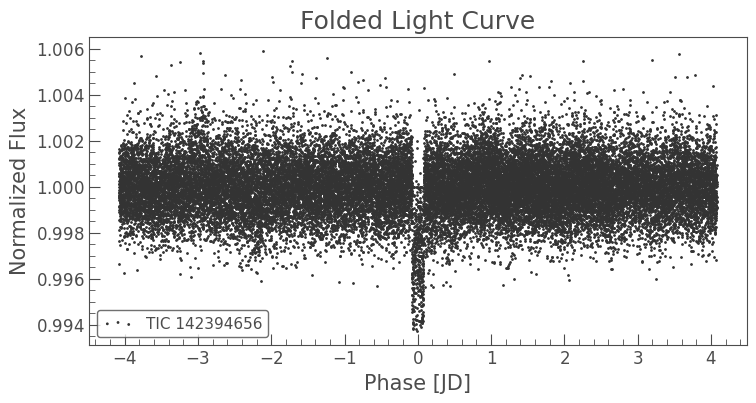

In [33]:
lc_folded = lc.fold(period=planet_b_period, epoch_time=planet_b_t0)
lc_folded.scatter()
plt.title('Folded Light Curve', fontsize=18)
plt.show();

In [34]:
def flux_at_time(t, F, Rp, Rs, c, t_ingress, t_duration, Period):
    """
    Calculate the flux at a given time during the transit.
    Parameters:
    - t: current time
    - F: flux from the star out of transit
    - Rp: radius of the planet
    - Rs: radius of the star
    - c: linear limb-darkening coefficient
    - t_ingress: time of ingress
    - t_duration: full duration of the transit
    Returns:
    - F_t: flux at time t
    """
    t_med = t_ingress+t_duration/2.
    r = Rs*2*(t-t_med)/t_duration
    lambda_val = np.sqrt((Rs**2-r**2)/Rs**2)

    depth = (Rp / Rs)**2 * (1 + c * lambda_val)
    delta_F = F * depth
    t_egress = t_ingress + t_duration
    if t < t_ingress or t > t_egress:
        return F
    else:
        return F - delta_F

<ipython-input-34-4290ce35613b>:17: RuntimeWarning: invalid value encountered in sqrt
  lambda_val = np.sqrt((Rs**2-r**2)/Rs**2)


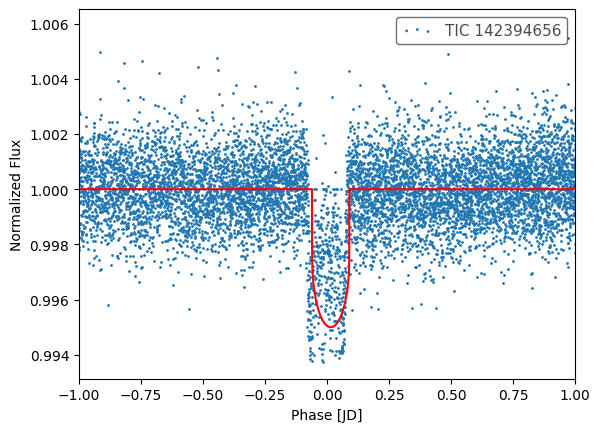

In [35]:
fig, ax = plt.subplots()

# Plot folded lc
lc_folded.scatter(ax=ax)

time = lc_folded['time'].value

# Plot model fit
F, Rp, Rs, c, t_ingress, t_duration, Period = 1, .05, 1, 1, -0.06, 0.15, planet_b_period
mod = [flux_at_time(t, F, Rp, Rs, c, t_ingress, t_duration, Period) for t in time]
plt.plot(time, np.array(mod), 'r')

plt.xlim((-1,1))
plt.show();

/usr/local/lib/python3.10/dist-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 22 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


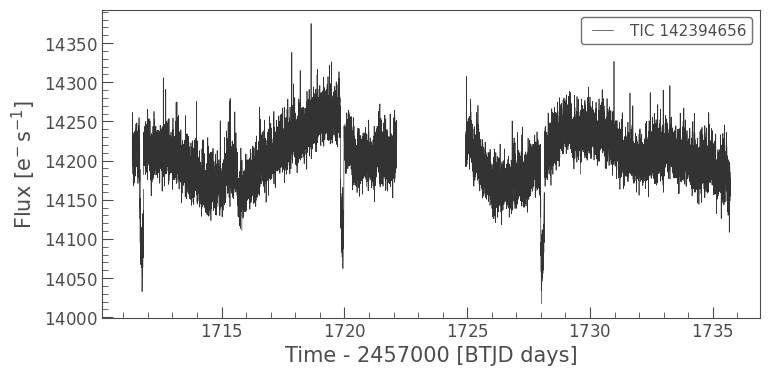

In [36]:
lc = search_result_lc.download(1)
lc.plot();

<ipython-input-34-4290ce35613b>:17: RuntimeWarning: invalid value encountered in sqrt
  lambda_val = np.sqrt((Rs**2-r**2)/Rs**2)


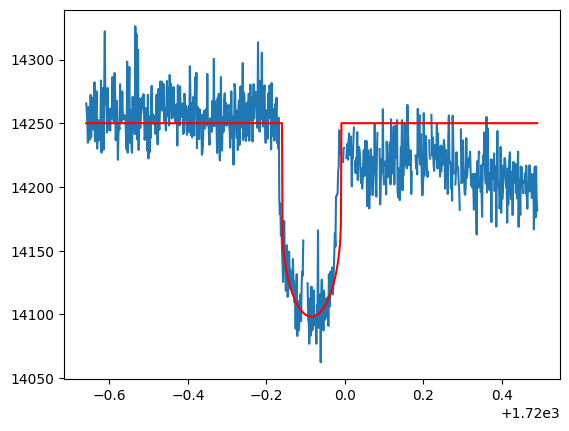

In [37]:
F, Rp, Rs, c, t_ingress, t_duration, Period = 14250, .073, 1, 1, 1719.84, planet_b_dur.value, planet_b_period
mod = [flux_at_time(t,F, Rp, Rs, c, t_ingress, t_duration, Period) for t in lc['time'].btjd]

fig = plt.figure()
filt = (lc['time'].btjd>t_ingress-.5) * (lc['time'].btjd<t_ingress+t_duration+.5)
plt.plot(lc['time'].btjd[filt], lc['flux'][filt])
plt.plot(lc['time'].btjd[filt], np.array(mod)[filt], 'r-')